# Face Mask Object Detection using Mobilenet

## preparation

In [17]:
import numpy as np
import pandas as pd
import os
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random as rand

In [18]:
INPUT_IMAGES_PATH = "/content/drive/My Drive/data/images/"
INPUT_ANNOTS_PATH = "/content/drive/My Drive/data/annotations/"

MODEL_PATH = "/content/drive/My Drive/data/model/mask_detector_mobilenet.h5"

In [19]:
def generate_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

In [20]:
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

In [21]:
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

## train dataset

In [22]:
imgs = list(sorted(os.listdir(INPUT_IMAGES_PATH)))
labels = list(sorted(os.listdir(INPUT_ANNOTS_PATH)))
print(imgs)
print(labels)

['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png', 'maksssksksss11.png', 'maksssksksss12.png', 'maksssksksss13.png', 'maksssksksss14.png', 'maksssksksss15.png', 'maksssksksss16.png', 'maksssksksss17.png', 'maksssksksss18.png', 'maksssksksss19.png', 'maksssksksss2.png', 'maksssksksss20.png', 'maksssksksss21.png', 'maksssksksss22.png', 'maksssksksss23.png', 'maksssksksss24.png', 'maksssksksss25.png', 'maksssksksss26.png', 'maksssksksss27.png', 'maksssksksss28.png', 'maksssksksss29.png', 'maksssksksss3.png', 'maksssksksss30.png', 'maksssksksss31.png', 'maksssksksss32.png', 'maksssksksss33.png', 'maksssksksss34.png', 'maksssksksss35.png', 'maksssksksss36.png', 'maksssksksss37.png', 'maksssksksss38.png', 'maksssksksss39.png', 'maksssksksss4.png', 'maksssksksss40.png', 'maksssksksss41.png', 'maksssksksss42.png', 'maksssksksss43.png', 'maksssksksss44.png', 'maksssksksss45.png', 'maksssksksss46.png', 'maksssksksss47.png', 'maksssksksss48.png', 'maksssksksss49.png', 'maksssksksss5

In [23]:
targets=[]
numobjs=[]

In [24]:
for i in range(len(imgs)):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join(INPUT_IMAGES_PATH, file_image)
    label_path = os.path.join(INPUT_ANNOTS_PATH, file_label)

    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)

In [25]:
face_images=[]
face_labels=[]

for i in range(len(imgs)):
    img_path = INPUT_IMAGES_PATH+"maksssksksss{}.png".format(i)

    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
        locs=(targets[i]['boxes'][j])
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

In [26]:
unique, counts = np.unique(face_labels, return_counts=True)

In [27]:
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)

In [28]:
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [29]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [30]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [31]:
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [32]:
del targets,face_images,face_labels

In [33]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})

Epoch 1/10
11/11 [==============================] - 17s 2s/step - loss: 2.0962 - accuracy: 0.6034 - val_loss: 0.6362 - val_accuracy: 0.7368
Epoch 2/10
11/11 [==============================] - 16s 1s/step - loss: 1.6403 - accuracy: 0.6868 - val_loss: 0.7395 - val_accuracy: 0.6737
Epoch 3/10
11/11 [==============================] - 16s 1s/step - loss: 1.4100 - accuracy: 0.7299 - val_loss: 0.5838 - val_accuracy: 0.7789
Epoch 4/10
11/11 [==============================] - 16s 1s/step - loss: 1.3074 - accuracy: 0.8103 - val_loss: 0.5804 - val_accuracy: 0.7895
Epoch 5/10
11/11 [==============================] - 16s 1s/step - loss: 1.1561 - accuracy: 0.7816 - val_loss: 0.5374 - val_accuracy: 0.8105
Epoch 6/10
11/11 [==============================] - 16s 1s/step - loss: 1.0938 - accuracy: 0.8132 - val_loss: 0.5506 - val_accuracy: 0.7895
Epoch 7/10
11/11 [==============================] - 16s 1s/step - loss: 0.9344 - accuracy: 0.8477 - val_loss: 0.4704 - val_accuracy: 0.8421
Epoch 8/10
11/11 [==

In [37]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.50      0.73      0.59        11
           1       0.94      0.90      0.92        81
           2       1.00      0.33      0.50         3

    accuracy                           0.86        95
   macro avg       0.81      0.65      0.67        95
weighted avg       0.89      0.86      0.87        95



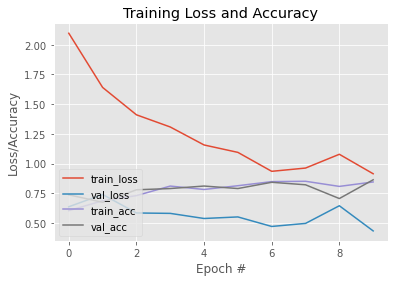

In [38]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [36]:
model.save(MODEL_PATH)